### Datasets
All data for each participant is contained in a folder numbered 001 through 016, with a separate CSV file for each feature. The seven features are:

- tri-axial accelerometry (ACC.csv),
- blood volume pulse (BVP.csv),
- interstitial glucose concentration (Dexcom.csv),
- EDA (EDA.csv),
- HR (HR.csv),
- IBI (IBI.csv), and
- skin temperature (TEMP.csv).
- Gender and HbA1c information for each participant can be found in file “Demographics.csv” in the root folder.


### Columns
A summary of the different data files is provided below. The raw output of Empatica E4 data has been modified from its original format for readability [2].

- ACC: data will include the “Timestamp” as a datetime value and accelerometer data will be given for the "X”, “Y”, “Z” orientation.
- BVP: refers to blood volume pulse; data will include “Timestamp” as a datetime value and “Value” as the measurement recorded at the time.
- Dexcom: refers to interstitial glucose concentration; data will include “Timestamp” as a datetime value and “Value” as the measurement recorded at the time.
- EDA: refers to electrodermal activity; data will include “Timestamp” as a datetime value and “Value” as the measurement recorded at the time.
- TEMP: refers to skin temperature; data will include “Timestamp” as a datetime value and “Value” as the measurement recorded at the time.
- IBI: refers to interbeat interval; data will include “Timestamp” as a datetime value and “Value” as the measurement recorded at the time.
- HR: refers to heart rate; data will include “Timestamp” as a datetime value and “Value” as the measurement recorded at the time.

### Data Source:
Cho, P., Kim, J., Bent, B., & Dunn, J. (2022). BIG IDEAs Lab Glycemic Variability and Wearable Device Data (version 1.0.0). PhysioNet. https://doi.org/10.13026/d742-0j82

In [1]:
# import dependencies
import os
import re
import pandas as pd
import datetime as datetime
import numpy as np
import matplotlib.pyplot as plt

In [34]:
 class CGM_Data:
    def __init__(self, n, path="physio/files/big-ideas-glycemic-wearable/1.0.0/"):
        self.n = n
        self.path = path
        self.df = -1
        self.dex = -1
        self.acc = -1
        self.tem = -1
        self.bvp = -1
        self.eda = -1
        self.hr = -1
        self.ibi = -1
        self.merged = -1
        self.norm = -1
        self.labeled = -1
        self.parse_file()
        self.get_merged()
    
    def parse_file(self):
        pn = '00{n}'.format(n=self.n)
        path = self.path+pn+'/'
        folder = [o for o in os.listdir(path) if '.csv' in o]
        dfs = [pd.read_csv(path+f) for f in folder]
        self.df = dict(zip(folder, dfs))

        dex = self.df['Dexcom_00{n}.csv'.format(n=self.n)].copy()
        # adjust dex dataframe
        mask = [col for col in dex.columns if len(dex[dex[col].notna()])<5] + \
                ['Event Subtype', 'Source Device ID', 'Index', \
                 'Event Type', 'Transmitter Time (Long Integer)',]
        dex = dex.drop(columns=mask)
        dex = dex[dex['Timestamp (YYYY-MM-DDThh:mm:ss)'].notna()]
        self.dex = dex.rename(columns={'Timestamp (YYYY-MM-DDThh:mm:ss)': 'datetime'})

        acc = self.df['ACC_00{n}.csv'.format(n=self.n)].copy()
        for col in acc.columns[1:]:
            acc[col] = acc[col].diff().abs()
        acc['tot'] = acc[' acc_x'] + acc[' acc_y'] + acc[' acc_z']
        self.acc = acc.drop(columns=[' acc_x',' acc_y',' acc_z'])

        self.tem = self.df['TEMP_00{n}.csv'.format(n=self.n)].copy()

        self.bvp = self.df['BVP_00{n}.csv'.format(n=self.n)].copy()

        self.eda = self.df['EDA_00{n}.csv'.format(n=self.n)].copy()

        self.hr = self.df['HR_00{n}.csv'.format(n=self.n)].copy()
        # formate hr['datetime']: change from 07-12 --> 02-13 to match ibi datetime
        self.hr['datetime'] = [h[:6]+'2'+h[7:9]+str(int(h[9])+1)+h[10:] for h in self.hr.datetime]

        self.ibi = self.df['IBI_00{n}.csv'.format(n=self.n)].copy()

    def get_merged(self):
        # copy dfs to explore & engineer features
        data = [self.dex.copy(), self.acc.copy(), self.tem.copy(), self.bvp.copy(), \
                self.eda.copy(), self.hr.copy(), self.ibi.copy()]

        # datetime to numeric
        for i in range(len(data)):
            data[i]['num_datetime'] = data[i]['datetime'].map(lambda x: \
                                      float(''.join(re.findall("([\d+.])", x))))

        # dex datetime for base comparison
        ddt = data[0]['num_datetime'].tolist()
        merged = data[0].copy()
        for i in range(1,len(data)):
            d = data[i]
            col = d.columns[1]
            mdt = [d[(d.num_datetime >= ddt[j]) & (d.num_datetime <= ddt[j+1])][col].mean() \
                   for j in range(len(ddt)-1)] + [d[col][d.index[-1]]]
            merged['mean_{}'.format(col.strip())] = mdt

        merged = merged.drop(columns=['num_datetime'])
        self.merged = merged.dropna()

        # normalize data
        norm = self.merged.drop(columns=['datetime'])
        self.norm = (norm-norm.min())/(norm.max()-norm.min())

    def get_corr(self): 
        # visualize correlation of merged data
        cr = self.norm.corr()
        return cr.style.background_gradient(cmap = 'coolwarm')

    def plot_window(start=0,end=100):
        # zoomed in line graph
        cln = self.norm.columns.tolist()
        self.norm[(cln[:3] + cln[4:7])].plot()
        plt.xlim(start, end)

    def add_labels(self):
        # add labels for data
        self.labeled = self.norm.copy()
        l = self.labeled['Glucose Value (mg/dL)']
        self.labeled['Labels'] = np.select(((l>l.mean()-1*l.std()) & (l<l.mean()+1*l.std()), \
                                  (l>l.mean()+1*l.std()), \
                                  (l<l.mean()-1*l.std())), \
                                 ('Norm', 'High', 'Low'),\
                                 np.nan)
        self.labeled['Labels'] = self.labeled.Labels.factorize()[0]

In [17]:
cgr = CGM_Data(n=1)

In [24]:
cgr.get_corr()

,Glucose Value (mg/dL),mean_tot,mean_temp,mean_bvp,mean_eda,mean_hr,mean_ibi
Glucose Value (mg/dL),1.000000,-0.097602,0.160814,-0.029986,-0.089520,-0.056889,0.023454
mean_tot,-0.097602,1.000000,-0.346483,-0.005501,-0.128633,0.775224,-0.648170
mean_temp,0.160814,-0.346483,1.000000,0.074295,0.320658,-0.443763,0.369628
mean_bvp,-0.029986,-0.005501,0.074295,1.000000,0.012939,-0.014535,-0.000778
mean_eda,-0.089520,-0.128633,0.320658,0.012939,1.000000,-0.119935,0.057299
mean_hr,-0.056889,0.775224,-0.443763,-0.014535,-0.119935,1.000000,-0.810428
mean_ibi,0.023454,-0.648170,0.369628,-0.000778,0.057299,-0.810428,1.000000


(0.0, 100.0)

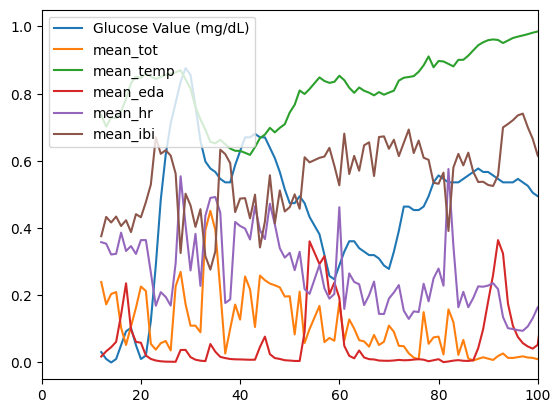

In [23]:
cgr.plot_window()

In [38]:
path = "physio/files/big-ideas-glycemic-wearable/1.0.0/"
path = [o for o in os.listdir(path) if o.find('.')==-1][1:4] # sampled 001-003

# # option 1
all_norms = []
for f in range(1,len(path)+1):
    cgr = CGM_Data(n=1)
    all_norms.append(cgr.norm)

# option 2
all_norms = [CGM_Data(n=i) for i in range(1,len(path)+1)]

## Regressor: 

In [41]:
# import model dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def run_rf(features, target, df):
    # Select features (X) and target (y)
    X = df[features]
    y = df[target]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                        random_state=42)
    
    # Initialize Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, warm_start=True) 
    
    # Train
    rf_model.fit(X_train, y_train)

    # Predict
    y_pred = rf_model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")
    
    # Calculate the percent accuracy
    accuracy_percentage = abs(100 * (1 - (mse / y_test.var())))
    print("Accuracy Percentage:", accuracy_percentage)

    # Visualize the predicted vs actual values
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Glucose Value')
    plt.ylabel('Predicted Glucose Value')
    plt.title('Actual vs Predicted Glucose Value')
    plt.show()

### RandomForest: 82% Accurancy
- ran on data with labels 
- possible future directions: CGM Classifier to make labels using CGM_Data 
- feed Classifier dataframe into Random Forest Regressor Model

In [144]:
con = pd.concat([a.labeled for a in all_norms])

Mean Squared Error: 0.0058648833668146
R-squared Score: 0.8206017502003972
Accuracy Percentage: 82.0843201411433


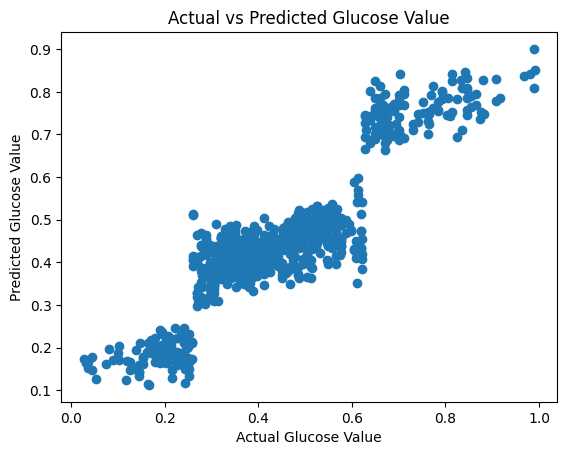

In [147]:
cln = con.columns.tolist()
features = cln[1:] # values + Labels
target = cln[0]
run_rf(features, target, con)